# Convolutional Neural Network for Aerial Cactus Identification
This notebook demonstrates training a CNN model to classify aerial images of terrain as containing a cactus or not. Key steps include:
- Loading and preprocessing training images
- Defining CNN model architecture  
- Training model with data augmentation
- Evaluating model performance
- Making predictions on test images

In [41]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall

In [42]:
def prepareImages(data, m, dataset, i=150, j=150, depth=1):
    """Load images and convert to numpy array.
    
    Args:
        data (DataFrame): Contains image ids to load.
        m (int): Number of images. 
        dataset (str): Path to image directory.
        i (int): Target image width.
        j (int): Target image height.  
        depth (int): Color channels (1 for grayscale, 3 for RGB).

    Returns:
        numpy.array: Images loaded into array of shape (m, i, j, depth).
    """
    print(f"Preparing {m} images from {dataset} directory, resized to {i}x{j}...")
    X = np.zeros((m, i, j, depth))
    for idx, image_id in enumerate(data['id']):
        img = Image.open(f"{dataset}/{image_id}").resize((i, j))
        if depth == 1:
            img = img.convert('L')
        X[idx] = np.array(img)
        if idx % 500 == 0:
            print(f"Loaded {idx+1}/{m} images")
    return X

In [43]:
def add_conv_block(model, filters, size, stride, padding='same'):
    """Add a convolutional block to the model"""
    model = Conv2D(filters, size, strides=stride, padding=padding, activation='relu')(model)
    model = MaxPooling2D(pool_size=2)(model) 
    model = BatchNormalization(axis=3)(model)
    model = Dropout(0.2)(model)
    return model

def build_model(input_shape, num_classes):
    """Define model architecture"""
    print(f"Building model for input shape {input_shape} and {num_classes} classes")
    inputs = Input(shape=input_shape)
    
    model = BatchNormalization(axis=3)(inputs)
    
    model = add_conv_block(model, 48, 5, 1)
    model = add_conv_block(model, 64, 5, 1)  
    model = add_conv_block(model, 128, 5, 1)
    model = add_conv_block(model, 160, 5, 1)
    model = add_conv_block(model, 192, 5, 1)

    model = Flatten()(model)
    outputs = Dense(num_classes, activation='sigmoid')(model)
    
    return Model(inputs=inputs, outputs=outputs)

In [44]:
def plot_history(history):
    """Plot training history"""
    print("Training history:")
    for metric, values in history.items():
        if not metric.startswith('val_'):
            print(f"{metric}: min={min(values):.4f}, max={max(values):.4f}")
            
    metrics = list(history.keys())
    num_metrics = len(metrics) // 2 + 1
    num_cols = 3
    num_rows = (num_metrics + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 16))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        if not metric.startswith('val_'):
            ax = axes[i]
            ax.plot(history[metric], marker='o')
            if metric != 'lr':
                ax.plot(history[f'val_{metric}'], marker='o')
            ax.set_title(metric)
            ax.set_xlabel('Epoch')
            ax.legend(['Train', 'Val'], loc='upper right')
            ax.grid()

In [45]:
# Load training data
train_df = pd.read_csv("train.csv")
width, height, depth = 32, 32, 3
num_classes = 1
batch_size = 16
epochs = 50

In [46]:
# Build model
model = build_model((width, height, depth), num_classes)
model.summary()

Building model for input shape (32, 32, 3) and 1 classes
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 3)        12        
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 48)        3648      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 48)       0         
 g2D)                                                            
                                                                 
 batch_normalization_13 (Bat  (None, 16, 16, 48)       192       
 chNormalization)                                                
  

In [47]:
# Load and preprocess images  
X = prepareImages(train_df, train_df.shape[0], "train/train", width, height, depth)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, train_df['has_cactus'], test_size=0.1, random_state=4)

Preparing 17500 images from train/train directory, resized to 32x32...
Loaded 1/17500 images
Loaded 501/17500 images
Loaded 1001/17500 images
Loaded 1501/17500 images
Loaded 2001/17500 images
Loaded 2501/17500 images
Loaded 3001/17500 images
Loaded 3501/17500 images
Loaded 4001/17500 images
Loaded 4501/17500 images
Loaded 5001/17500 images
Loaded 5501/17500 images
Loaded 6001/17500 images
Loaded 6501/17500 images
Loaded 7001/17500 images
Loaded 7501/17500 images
Loaded 8001/17500 images
Loaded 8501/17500 images
Loaded 9001/17500 images
Loaded 9501/17500 images
Loaded 10001/17500 images
Loaded 10501/17500 images
Loaded 11001/17500 images
Loaded 11501/17500 images
Loaded 12001/17500 images
Loaded 12501/17500 images
Loaded 13001/17500 images
Loaded 13501/17500 images
Loaded 14001/17500 images
Loaded 14501/17500 images
Loaded 15001/17500 images
Loaded 15501/17500 images
Loaded 16001/17500 images
Loaded 16501/17500 images
Loaded 17001/17500 images


In [48]:
#shape of the data
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(15750, 32, 32, 3) (1750, 32, 32, 3) (15750,) (1750,)


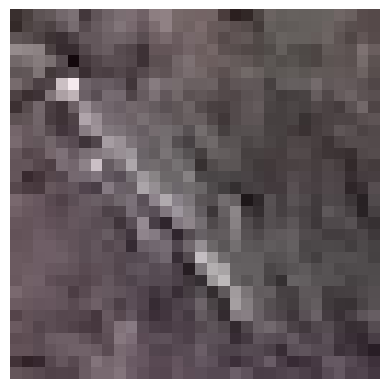

In [49]:
# Supposons que X_train est déjà chargé et contient vos images
image = X_train[20]
# Si les valeurs sont des entiers entre 0 et 255, vous pouvez les convertir en flottants:
image = image.astype('float32') / 255.0

# Afficher l'image
plt.imshow(image)
plt.axis('off')
plt.show()

In [50]:
print("Total of images",len(X_train),",and number of images with cactus",y_train.sum())

Total of images 15750 ,and number of images with cactus 11799


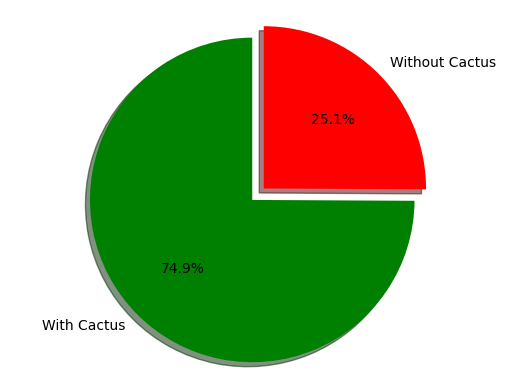

In [51]:
# Données
labels = 'With Cactus', 'Without Cactus'
sizes = [y_train.sum(), len(X_train) - y_train.sum()]  # Nombre d'images avec et sans cactus
colors = ['green', 'red']
explode = (0.1, 0)  # mise en exergue du premier segment

# Création du graphique
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Afficher le graphique
plt.show()

data is unbalanced

In [55]:
#Oversampling
import cv2

def add_noise(img,variance=0.1,mean=0):
    """add gaussian noise to an image"""
    noise = np.random.normal(mean, variance, img.shape)
    img += noise
    img = np.clip(img, 0., 1.)
    return img

def rotation(img, angle=90):
    """rotate an image by a given angle in degrees"""
    return np.rot90(img, k=angle//90)

def luminosity(img, factor=1):
    """change the luminosity of an image"""
    return np.clip(img * factor, 0., 1.)


import numpy as np
import cv2

def random_zoom(img, min_factor=0.5, max_factor=1.5):
    """Apply random zooming within a range to an image."""
    if min_factor >= max_factor:
        raise ValueError("min_factor must be less than max_factor")
    
    # Générer un facteur de zoom aléatoire entre min_factor et max_factor
    factor = np.random.uniform(min_factor, max_factor)
    h, w = img.shape[:2]
    new_h = int(h * factor)
    new_w = int(w * factor)
    
    if factor < 1.0:
        # Pour un facteur de zoom inférieur à 1, nous effectuons un crop aléatoire
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        cropped = img[top:top + new_h, left:left + new_w]
        img = cv2.resize(cropped, (w, h), interpolation=cv2.INTER_LINEAR)
    else:
        # Pour un facteur de zoom supérieur à 1, nous agrandissons l'image
        resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        # S'assurer que la zone à cropper existe encore
        top = np.random.randint(0, max(1, new_h - h))
        left = np.random.randint(0, max(1, new_w - w))
        img = resized[top:top + h, left:left + w]

    return img


def oversampling(df, n):
    """Oversampling the dataframes df with adding n images"""
    new_df=[]
    for i in range(n):
        img_random=df[np.random.randint(0, len(df))].copy()
        if np.random.rand() < 0.5:
            img_random = rotation(img_random, angle=np.random.choice([90, 180, 270]))
        if np.random.rand() < 0.5:
            img_random = luminosity(img_random, factor=np.random.uniform(0.5, 1.5))
        if np.random.rand() < 0.5:
            img_random = add_noise(img_random, variance=np.random.uniform(0, 0.05))
        if np.random.rand() < 0.5:
            img_random = random_zoom(img_random, min_factor=0.5, max_factor=1.5)
        new_df.append(img_random)
    new_df=np.array(new_df)
    return new_df

def normalize(X):
    """Normalize the data assuming X can be a single image (3D) or multiple images (4D)."""
    # Convert to float32 for precision and perform normalization
    return X.astype('float32') / 255.0
     

In [56]:
X_train_noCactus = X_train[y_train == 0]

#normalization
X_train_noCactus=normalize(X_train_noCactus)

#oversampling
n=len(y_train[y_train == 1])-len(y_train[y_train == 0])
X_train_noCactus=oversampling(X_train_noCactus,n)
y_train_noCactus=np.zeros(n)

print("Total of images",len(X_train_noCactus),",and number of images with cactus",y_train_noCactus.sum())

Total of images 7848 ,and number of images with cactus 0.0


In [58]:
#add the new images to the training set
X_train=np.concatenate((X_train,X_train_noCactus))
y_train=np.concatenate((y_train,y_train_noCactus))



In [60]:
print(len(X_train),"balanced? ",y_train.sum())

23598 balanced?  11799.0


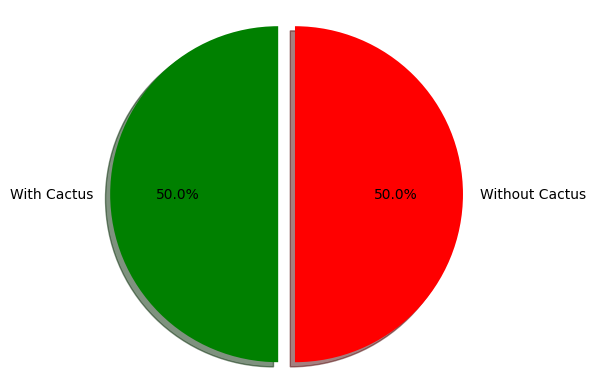

In [61]:
#check if data is balanced
# Données
labels = 'With Cactus', 'Without Cactus'
sizes = [y_train.sum(), len(X_train) - y_train.sum()]  # Nombre d'images avec et sans cactus
colors = ['green', 'red']
explode = (0.1, 0)  # mise en exergue du premier segment

# Création du graphique
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Afficher le graphique
plt.show()

(6, 32, 32, 3)


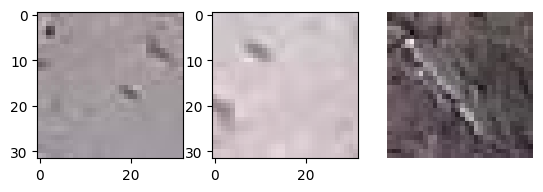

In [152]:
##test

# Supposons que X_train est déjà chargé et contient vos images
image = X_train[20].copy()
image_original = X_train[20]
# Si les valeurs sont des entiers entre 0 et 255, vous pouvez les convertir en flottants:
image = image.astype('float32') / 255.0
image_original = image_original.astype('float32') / 255.0

test_dataset=np.array([normalize(X_train[1]),normalize(X_train[2]),normalize(X_train[3])])
plt.subplot(1, 3, 1)
plt.imshow(test_dataset[1])
test_images=oversampling(test_dataset,3)
print(test_images.shape)
# Afficher l'image
plt.subplot(1, 3, 2)
plt.imshow(test_images[3])
plt.subplot(1, 3, 3)
plt.imshow(image_original)
plt.axis('off')
plt.show()

In [62]:
# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

# Set up data augmentation 
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)
aug.fit(X_train)

Epoch 1/10
738/738 [==============================] - 81s 110ms/step - loss: 0.1000 - auc: 0.9935 - precision: 0.9604 - recall: 0.9630 - val_loss: 0.1457 - val_auc: 0.9917 - val_precision: 0.9330 - val_recall: 1.0000
Epoch 2/10
738/738 [==============================] - 86s 117ms/step - loss: 0.0889 - auc: 0.9948 - precision: 0.9661 - recall: 0.9680 - val_loss: 0.1810 - val_auc: 0.9862 - val_precision: 0.9284 - val_recall: 0.9985
Epoch 3/10
738/738 [==============================] - 86s 117ms/step - loss: 0.0775 - auc: 0.9958 - precision: 0.9698 - recall: 0.9722 - val_loss: 0.1145 - val_auc: 0.9918 - val_precision: 0.9845 - val_recall: 0.9529
Epoch 4/10
738/738 [==============================] - 86s 117ms/step - loss: 0.0681 - auc: 0.9968 - precision: 0.9758 - recall: 0.9751 - val_loss: 0.2856 - val_auc: 0.9892 - val_precision: 0.8767 - val_recall: 1.0000
Epoch 5/10
738/738 [==============================] - 85s 115ms/step - loss: 0.0590 - auc: 0.9974 - precision: 0.9784 - recall: 0.97

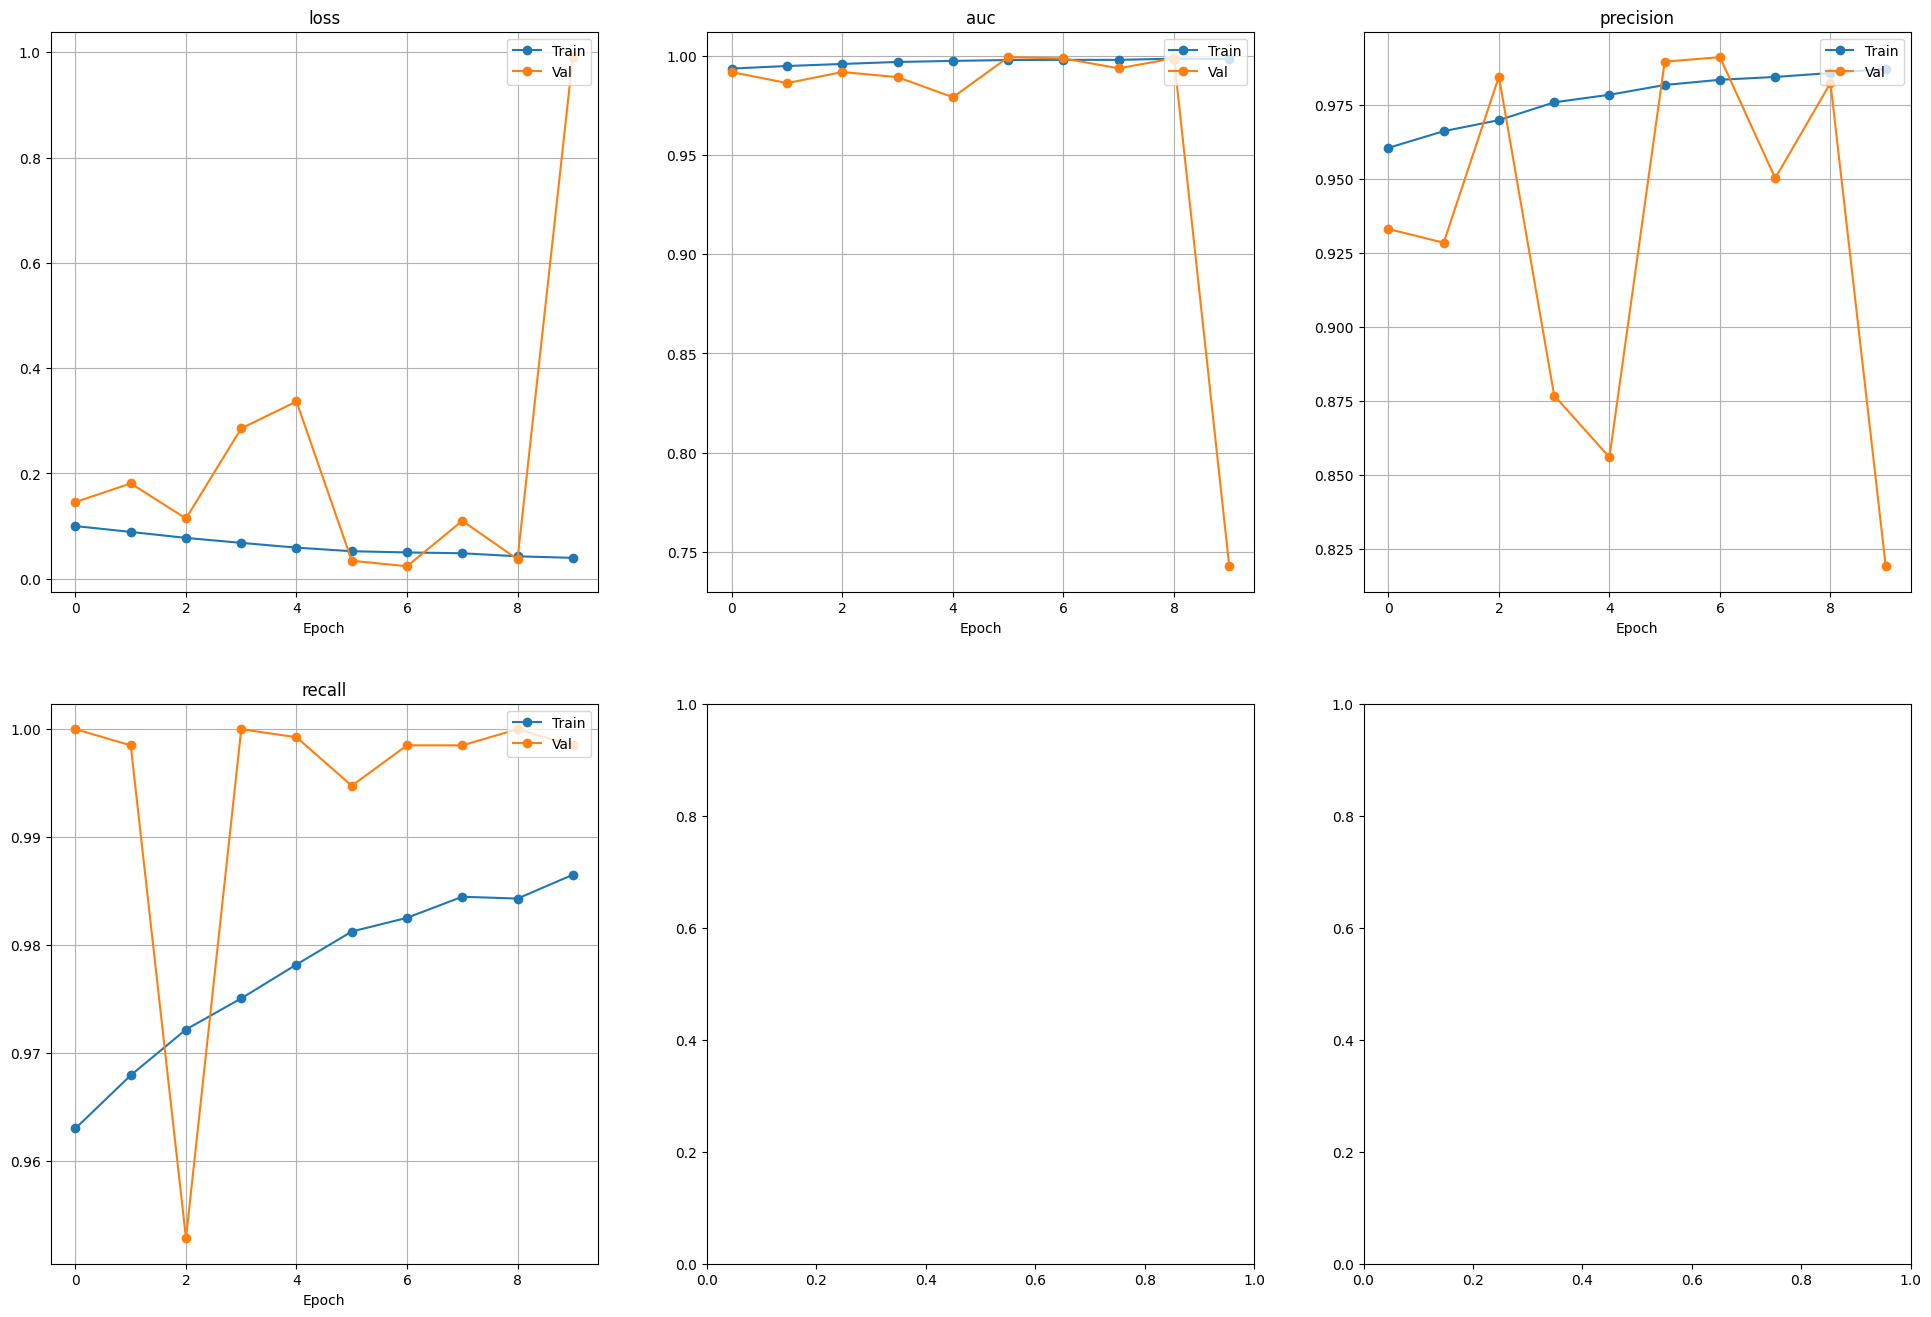

In [66]:
# Train model
history = model.fit(
    aug.flow(X_train, y_train, batch_size=32),
    epochs=10, 
    validation_data=(X_val, y_val)
)

# Plot training history
plot_history(history.history)

In [10]:
# Load and preprocess test images
test_df = pd.DataFrame({'id': os.listdir("test/test/")}) 
X_test = prepareImages(test_df, test_df.shape[0], "test/test/", width, height, depth)

# Make predictions on test images
preds = model.predict(X_test)
preds = (preds > 0.5).astype(int)

# Save predictions to CSV
output_df = pd.DataFrame({'id': test_df['id'], 'has_cactus': preds.flatten()})
output_df.to_csv('submission.csv', index=False)
print("Predictions saved to submission.csv")

Preparing 4000 images from aerial-cactus/test/test/ directory, resized to 32x32...
Loaded 1/4000 images
Loaded 501/4000 images
Loaded 1001/4000 images
Loaded 1501/4000 images
Loaded 2001/4000 images
Loaded 2501/4000 images
Loaded 3001/4000 images
Loaded 3501/4000 images
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predictions saved to submission.csv


# Reference
- Angrew Ng & Coursera - https://www.coursera.org/learn/machine-learning
- Anezka Kolaceke - https://www.kaggle.com/anezka/cnn-with-keras-for-humpback-whale-id
- Peter - https://www.kaggle.com/pestipeti/keras-cnn-starter
- Yassine Ghouzam, PhD - https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
- Martin Piotte - https://www.kaggle.com/martinpiotte/bounding-box-model